# Convolutional Neural Network (CNN)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/02_cnn/cnn.ipynb)

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as Transforms
from torchsummary import summary

from matplotlib import pyplot as plt

## 0. Train parameters

In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 5e-4

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare datset

In [3]:
def get_dataloaders(batch_size):

    # Dataset classes
    classes = np.array([
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ])

    # first define a transform funcion, to make images tensors and normalize them
    transform = Transforms.Compose(
        [Transforms.ToTensor(),
         Transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # download Cifar-10 datset
    train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

    train_loader = DataLoader(dataset=train_ds, batch_size=batch_size,
                              shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_ds, batch_size=batch_size,
                             shuffle=False, num_workers=4)

    return classes, train_loader, test_loader

checking datasets and labels.

Files already downloaded and verified
Files already downloaded and verified


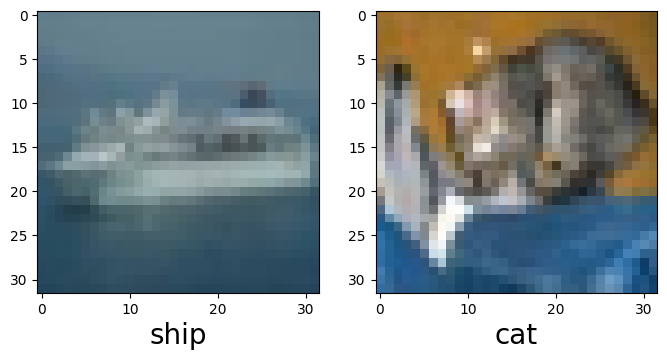

In [4]:
classes, train_loader, test_loader = get_dataloaders(batch_size=8)

check_train_img, check_train_label = next(iter(train_loader))
check_test_img, check_test_label = next(iter(test_loader))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# display the images and corresponded labels

# To plot pytorch normalized image:
# 1. Change the shape: (channel, h, w) -> (h, w, channel)
# 2. Unnormalize image: img / 2 + 0.5
train_img = check_train_img[0].permute(1, 2, 0) / 2 + 0.5
test_img = check_test_img[0].permute(1, 2, 0) / 2 + 0.5

axes[0].imshow(train_img)
axes[0].set_xlabel(classes[check_train_label[0].item()], fontsize=20)
axes[1].imshow(test_img)
axes[1].set_xlabel(classes[check_test_label[0].item()], fontsize=20)

plt.show()

In [5]:
print(check_train_img.shape)

torch.Size([8, 3, 32, 32])


## 2. Define the CNN network

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            # Conv. Block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            # Conv. Block 2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            # Conv. Block 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            # Conv. Block 4
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Flatten(),

            # Fully Connected Network
            nn.Linear(in_features=1600, out_features=128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            # Output
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        return self.model(x)

Model summary in PyTorch

In [7]:
cnn = CNN(NUM_CLASSES).to(DEVICE)
summary(cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
       BatchNorm2d-2           [-1, 32, 30, 30]              64
         LeakyReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
       BatchNorm2d-5           [-1, 32, 14, 14]              64
         LeakyReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
       BatchNorm2d-8           [-1, 64, 12, 12]             128
         LeakyReLU-9           [-1, 64, 12, 12]               0
           Conv2d-10             [-1, 64, 5, 5]          36,928
      BatchNorm2d-11             [-1, 64, 5, 5]             128
        LeakyReLU-12             [-1, 64, 5, 5]               0
          Flatten-13                 [-1, 1600]               0
           Linear-14                  [

## 3. Define the model, objective, and optimizer

In [8]:
cnn = CNN(num_classes=NUM_CLASSES).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    cnn = torch.compile(cnn) # PyTorch 2.0 feature
    print('model compiled')

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(cnn.parameters(), lr=LR)

model compiled


## 4. Get dataloaders

In [9]:
classes, train_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


## 5. Define train and validation functions

In [10]:
def train(model, dataloader, optimizer, loss_fn):
    
    model.train()
    correct_preds = 0
    total_preds = 0
    train_loss = 0.0
    
    for i, (train_x, train_y) in enumerate(dataloader):
        # clear gradients
        optimizer.zero_grad()
        
        train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
        pred_y = model(train_x)
        loss = loss_fn(pred_y, train_y)
        
        loss.backward()
        optimizer.step()

        correct_preds += sum(pred_y.argmax(dim=-1) == train_y).item()
        total_preds += len(pred_y)
        train_loss += loss.item()

    return train_loss / len(dataloader), correct_preds / total_preds


def validate(model, dataloader, loss_fn):
    
    model.eval()    
    correct_preds = 0
    total_preds = 0
    val_loss = 0.0

    for i, (val_x, val_y) in enumerate(dataloader):
        # We need to first send data to the training device
        val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
        # no grad needed in evaluation
        with torch.no_grad():
            pred_y = model(val_x)
            loss = loss_fn(pred_y, val_y)

        val_loss += loss.item()
        correct_preds += sum(pred_y.argmax(dim=-1) == val_y).item()
        total_preds += len(pred_y)

    return val_loss / len(dataloader), correct_preds / total_preds

## 6. Train and evaluate

In [11]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [12]:
for i in range(NUM_EPOCHS):
    train_loss, train_acc = train(cnn, train_loader, optim, loss_fn)
    val_loss, val_acc = validate(cnn, test_loader, loss_fn)

    metrics_history['train_loss'].append(train_loss)
    metrics_history['train_accuracy'].append(train_acc)
    metrics_history['test_loss'].append(val_loss)
    metrics_history['test_accuracy'].append(val_acc)

    print('Epoch {}:'.format(i + 1))
    print(f'\tTrain - loss: {metrics_history["train_loss"][-1]:.4f}, accuracy: {metrics_history["train_accuracy"][-1] * 100:.4f}')
    print(f'\tTest - loss: {metrics_history["test_loss"][-1]:.4f}, accuracy: {metrics_history["test_accuracy"][-1] * 100:.4f}')

[2023-05-22 20:42:46,432] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2023-05-22 20:42:56,063] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch 1:
	Train - loss: 1.4571, accuracy: 47.7960
	Test - loss: 1.1281, accuracy: 59.3100
Epoch 2:
	Train - loss: 1.0868, accuracy: 61.8020
	Test - loss: 0.9504, accuracy: 66.2200
Epoch 3:
	Train - loss: 0.9279, accuracy: 67.8480
	Test - loss: 0.8560, accuracy: 69.9600
Epoch 4:
	Train - loss: 0.8259, accuracy: 71.2940
	Test - loss: 0.7961, accuracy: 71.9600
Epoch 5:
	Train - loss: 0.7473, accuracy: 74.2160
	Test - loss: 0.7650, accuracy: 72.9900
Epoch 6:
	Train - loss: 0.6925, accuracy: 75.9660
	Test - loss: 0.7590, accuracy: 73.4800
Epoch 7:
	Train - loss: 0.6443, accuracy: 77.4860
	Test - loss: 0.7242, accuracy: 74.9600
Epoch 8:
	Train - loss: 0.5966, accuracy: 79.3320
	Test - loss: 0.7478, accuracy: 74.3900
Epoch 9:
	Train - loss: 0.5504, accuracy: 80.5440
	Test - loss: 0.7563, accuracy: 74.5600
Epoch 10:
	Train - loss: 0.5172, accuracy: 81.6380
	Test - loss: 0.7628, accuracy: 74.4300


## 8. Visualize metrics

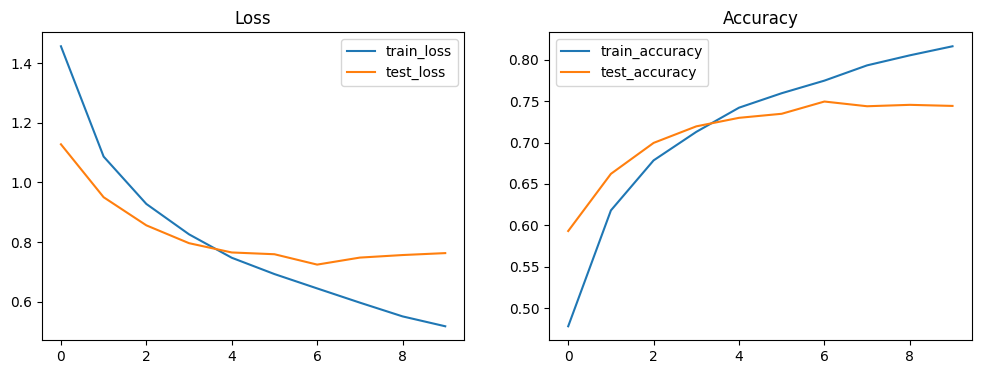

<Figure size 640x480 with 0 Axes>

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 9. Check predictions

In [14]:
imgs, true_labels = next(iter(test_loader))

with torch.no_grad():
    logits = cnn(imgs.to(DEVICE))
    
preds = logits.argmax(-1).detach().cpu()

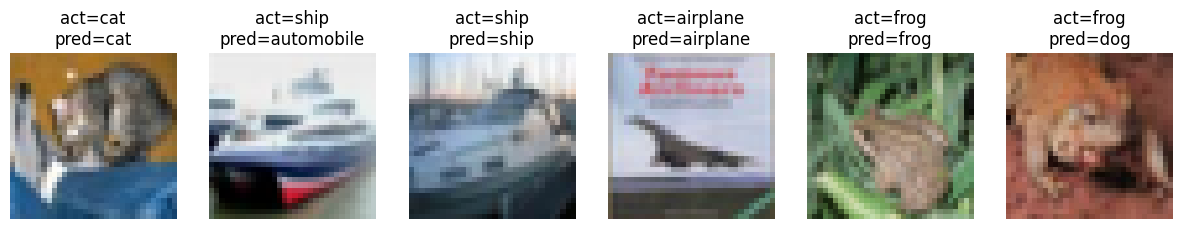

In [15]:
num_to_show = 6
indices = np.random.choice(np.arange(len(imgs)), num_to_show, replace=True)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, idx in enumerate(indices):
    img = imgs[i].permute(1, 2, 0) / 2 + 0.5
    ax = fig.add_subplot(1, num_to_show, i+1, label='test')
    ax.axis('off')
    
    pred_class = classes[preds[i]]
    true_class = classes[true_labels[i]]
    
    ax.imshow(img)
    ax.set_title(f'act={true_class}\npred={pred_class}')

plt.show()